In [1]:
import json
import pandas as pd
from eventtrader import keys
from langchain_mcp_adapters.client import MultiServerMCPClient
from langchain.tools import tool
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.messages import HumanMessage, AIMessage


# MCP Client Tool

### declare mcp_client once globally

In [2]:
mcp_client = MultiServerMCPClient({
"neo4j": {
    "url": "http://localhost:31380/mcp",
    "transport": "streamable_http",
        }
    })

Neo4j MCP Tool

In [3]:
@tool
async def run_cypher_query(query: str) -> str:
    """Executes a Cypher query on the Neo4j MCP server."""

    tools = await mcp_client.get_tools()
    read_tool = next(t for t in tools if t.name == "read_neo4j_cypher")
    result = await read_tool.ainvoke({"query": query})
    return json.loads(result)



sample query

In [4]:
# Example usage:
cypher_query = "MATCH (n:News) RETURN n LIMIT 1;"
data = await run_cypher_query.ainvoke(cypher_query)
data[0]["n"]

{'returns_schedule': '{"hourly": "2023-01-05T15:31:29-05:00", "session": "2023-01-05T16:00:00-05:00", "daily": "2023-01-05T16:00:00-05:00"}',
 'created': '2023-01-05T14:31:29-05:00',
 'title': "Darling Ingredients Says We're Maintaining Guidance For 2022, Giving Guidance Of 20% Growth For 2023",
 'body': '',
 'url': 'https://www.benzinga.com/news/23/01/30300128/darling-ingredients-says-were-maintaining-guidance-for-2022-giving-guidance-of-20-growth-for-2023',
 'tags': '[]',
 'market_session': 'in_market',
 'channels': '["News", "Guidance"]',
 'id': 'bzNews_30300128',
 'embedding': [0.018065182492136955,
  0.010608648881316185,
  -0.014585962519049644,
  0.014429843984544277,
  0.04960119351744652,
  -0.006070050410926342,
  -0.037884846329689026,
  0.011664309538900852,
  -0.03488141670823097,
  0.0017442565876990557,
  0.026302311569452286,
  0.013225498609244823,
  0.03045061230659485,
  -0.023165065795183182,
  -0.021261902526021004,
  0.016414783895015717,
  -0.015626754611730576,


# Foundational Models

In [5]:
from langgraph.graph import StateGraph, START, END
from langgraph.graph import MessagesState
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display
from langgraph.prebuilt import create_react_agent


### tools

In [6]:
from langchain_openai import ChatOpenAI
tools = await mcp_client.get_tools()
[print(f"- {tool.name}: {tool.description}") for tool in tools]

- get_neo4j_schema: List all node, their attributes and their relationships to other nodes in the neo4j database.
        If this fails with a message that includes "Neo.ClientError.Procedure.ProcedureNotFound"
        suggest that the user install and enable the APOC plugin.
        
- read_neo4j_cypher: Execute a read Cypher query on the neo4j database.
- write_neo4j_cypher: Execute a write Cypher query on the neo4j database.


[None, None, None]

#### schema_tool

In [7]:
schema_tool = next(t for t in tools if t.name == "get_neo4j_schema")
schema_result = await schema_tool.ainvoke({})
print(f"Schema result type: {type(schema_result)}")
print(f"Schema result (truncated): {str(schema_result)[:200]}...")

Schema result type: <class 'str'>
Schema result (truncated): [{"label": "MarketIndex", "attributes": {"id": "STRING unique indexed", "ticker": "STRING", "etf": "STRING", "name": "STRING"}, "relationships": {}}, {"label": "Sector", "attributes": {"id": "STRING u...


#### read_tool

In [8]:
read_tool = next(t for t in tools if t.name == "read_neo4j_cypher")
result = await read_tool.ainvoke({"query": "MATCH (c:Company) RETURN c.name LIMIT 2"})
print(f"Direct Cypher Query result: {result}")

Direct Cypher Query result: [{"c.name": "FMC CORP"}, {"c.name": "SCOTTS MIRACLE-GRO CO"}]


### llm_with_tools

In [ ]:

# Create LLM with tools (requires OpenAI API key)
gpt4o_chat = ChatOpenAI(model="gpt-4o", temperature=0)
gpt35_chat = ChatOpenAI(model="gpt-3.5-turbo-0125", temperature=0)

llm = ChatOpenAI(model="gpt-4", temperature=0)
llm_with_tools = llm.bind_tools(tools)

### single-pass non-reactive agent graph

{'messages': [HumanMessage(content='Find and list any one node in my the database?', additional_kwargs={}, response_metadata={}, id='57146f0e-d82c-48ca-9ede-4d4c5ecbcaf8'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_xpoC7IJai9evN7owI3i33TrY', 'function': {'arguments': '{\n  "query": "MATCH (n) RETURN n LIMIT 1"\n}', 'name': 'read_neo4j_cypher'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 29, 'prompt_tokens': 215, 'total_tokens': 244, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4-0613', 'system_fingerprint': None, 'id': 'chatcmpl-C0t97k1ha4QD47ilwkZB21HoyrPyl', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--64f417cc-9aa0-4b69-9732-ea64d0757046-0', tool_calls=[{'name': 'read_neo4j_cypher', 'arg

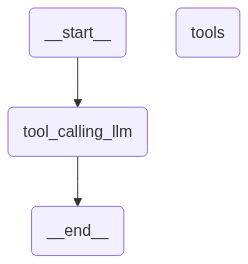

In [10]:

# Define the tool-calling node
def tool_calling_llm(state: MessagesState):
    """Node that calls the LLM with tools."""
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


# Build the graph
builder = StateGraph(MessagesState)

# Add nodes
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools))  # MCP tools work like any tools!

# Add edges (following router.ipynb pattern)
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    lambda x: END,  # For testing, always end (normally use tools_condition)
)
builder.add_edge("tools", "tool_calling_llm")

# Compile the graph
graph = builder.compile()

response = await graph.ainvoke({
    "messages": [{"role": "user", "content": "Find and list any one node in my the database?"}]})

print(response)

display(Image(graph.get_graph().draw_mermaid_png()))

#### React agent graph


🔍 Query: What types of nodes exist in the database? List the first 3.
💬 Response: The first three types of nodes in the database are:

1. **MarketIndex**: This node has attributes like id, ticker, etf, and name. Currently, it doesn't have any relationships with other nodes.

2. **Sector**: This node has attributes like id, etf, and name. It has a relationship "BELONGS_TO" with the MarketIndex node.

3. **Industry**: This node has attributes like id, sector_id, etf, and name. It has a relationship "BELONGS_TO" with the Sector node.

🔍 Query: How many Report nodes are there in the database?
💬 Response: There are 31,618 Report nodes in the database.

🔍 Query: Show me 2 companies (Company nodes) with their names.
💬 Response: Here are two companies:

1. FMC CORP
2. SCOTTS MIRACLE-GRO CO


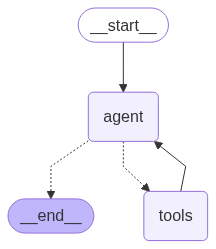

In [11]:
# Define the agent node (router.ipynb pattern)
# def agent(state: MessagesState):
#     """Agent node that decides whether to use tools."""
#     return {"messages": [llm_with_tools.invoke(state["messages"])]}

react_agent = create_react_agent("openai:gpt-4", tools)
builder = StateGraph(MessagesState)

# Add nodes
builder.add_node("agent", react_agent)
builder.add_node("tools", ToolNode(tools))

# Add edges (router pattern)
builder.add_edge(START, "agent")
builder.add_conditional_edges("agent",
    tools_condition,
    # If tools_condition returns "tools", go to tools node
    # If it returns "__end__", go to END
)
builder.add_edge("tools", "agent")

graph = builder.compile()

queries = [
    "What types of nodes exist in the database? List the first 3.",
    "How many Report nodes are there in the database?",
    "Show me 2 companies (Company nodes) with their names.",
]

for query in queries:
    print(f"\n🔍 Query: {query}")
    result = await graph.ainvoke({
        "messages": [HumanMessage(content=query)]
    })
    print(f"💬 Response: {result['messages'][-1].content}")


display(Image(graph.get_graph().draw_mermaid_png()))

### practice (to be made fair)


In [ ]:
from typing_extensions import TypedDict
from typing import Literal


class State(TypedDict):
    graph_state: str